In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer

/Users/nimakondori/miniconda3/envs/llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model=AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map='mps',
    torch_dtype='auto', 
    trust_remote_code=True,
)
tokenizer=AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")
inputs = tokenizer("Your input text here", add_special_tokens=True)


`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.26s/it]


In [3]:
prompt = "Write an email apologizing to Sarah for the tragic" \
         "gardening mishap. Explain how it happened.<|assistant|>"

input_ids = tokenizer.encode(prompt, return_tensors="pt")  # Return as PyTorch tensor


In [4]:
# Tokenize the input prompt with special tokens
input_ids = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).input_ids.to("mps")

# Generate the text
generation_output = model.generate(
    input_ids=input_ids,
    max_new_tokens=20
)

# Print the output with special tokens included
print(tokenizer.decode(generation_output[0], skip_special_tokens=False))

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48
You are not running the flash-attention implementation, expect numerical differences.


Write an email apologizing to Sarah for the tragicgardening mishap. Explain how it happened.<|assistant|> Subject: Sincere Apologies for the Gardening Mishap


Dear


In [5]:
tokenizer.add_special_tokens({
    'additional_special_tokens': ['<|assistant|>', '</s>']
})
model.resize_token_embeddings(len(tokenizer))

Embedding(32011, 3072, padding_idx=32000)

In [6]:
tokens = model.generate(input_ids=input_ids,
    max_new_tokens=20)
print(tokenizer.convert_ids_to_tokens(tokens[0]))

['▁Write', '▁an', '▁email', '▁apolog', 'izing', '▁to', '▁Sarah', '▁for', '▁the', '▁trag', 'ic', 'g', 'arden', 'ing', '▁m', 'ish', 'ap', '.', '▁Exp', 'lain', '▁how', '▁it', '▁happened', '.', '<|assistant|>', '▁Sub', 'ject', ':', '▁S', 'inc', 'ere', '▁Ap', 'ologies', '▁for', '▁the', '▁Garden', 'ing', '▁M', 'ish', 'ap', '<0x0A>', '<0x0A>', '<0x0A>', 'D', 'ear']


# Decoding Strategy


In [7]:
prompt = "The capital of France is" 

input_ids = tokenizer(prompt, return_tensors='pt').input_ids.to('mps')  

output = model.generate(
    input_ids=input_ids,
    max_new_tokens=20,
)

model_output = model.model(input_ids)
lm_head = model.lm_head(model_output[0])

In [8]:
print(lm_head.shape) 

torch.Size([1, 5, 32011])


In [9]:
lm_head.argmax(dim=-1)

tensor([[ 775,  310,  278,  338, 3681]], device='mps:0')

In [10]:
# decode the lm head most probable outputs
lm_head_tokens = tokenizer.decode(lm_head.argmax(dim=-1)[0])  
print(lm_head_tokens)

code of the is Paris


# Sentiment Analysis

In [11]:
from datasets import load_dataset

data = load_dataset('rotten_tomatoes')

data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [12]:
data['train'][0, -1]

{'text': ['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
  'things really get weird , though not particularly scary : the movie is all portent and no content .'],
 'label': [1, 0]}

In [13]:
from transformers import pipeline

model_path = 'cardiffnlp/twitter-roberta-base-sentiment-latest'

pipe = pipeline(
    model=model_path,
    tokenizer=model_path, # model path is enough
    return_all_scores=True,
    device='mps'
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

In [14]:
import numpy as np  
from tqdm import tqdm
from transformers.pipelines.pt_utils import KeyDataset

y_pred = []
for output in tqdm(pipe(KeyDataset(data['test'], "text")), total=len(data['test'])):
    negative_score = output[0]['score']
    positive_score = output[2]['score']
    assignment = np.argmax([negative_score, positive_score])    
    y_pred.append(assignment)

100%|██████████| 1066/1066 [00:36<00:00, 29.53it/s]


In [15]:
from sklearn.metrics import classification_report

def evaluate_performance(y_true, y_pred):
    performance = classification_report(y_true, y_pred, target_names=['negative_reviews', 'positive_reviews'])
    print(performance)

evaluate_performance(data["test"]["label"], y_pred)


                  precision    recall  f1-score   support

negative_reviews       0.76      0.88      0.81       533
positive_reviews       0.86      0.72      0.78       533

        accuracy                           0.80      1066
       macro avg       0.81      0.80      0.80      1066
    weighted avg       0.81      0.80      0.80      1066



# Logistic Regression
In the next section we will extract embeddings from an embedding model and train classifier on top of it to 
improve the performance of the above model

In [17]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')  

In [18]:
# Prepare the data and the classifier heads

train_embeddings = model.encode(data['train']['text'], show_progress_bar=True)

test_embeddings = model.encode(data['test']['text'], show_progress_bar=True)

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state=42)
classifier.fit(train_embeddings, data['train']['label'])

Batches: 100%|██████████| 34/34 [00:03<00:00,  9.71it/s]


LogisticRegression(random_state=42)

In [19]:
y_pred = classifier.predict(test_embeddings)
evaluate_performance(data['test']['label'], y_pred)

                  precision    recall  f1-score   support

negative_reviews       0.85      0.86      0.85       533
positive_reviews       0.86      0.85      0.85       533

        accuracy                           0.85      1066
       macro avg       0.85      0.85      0.85      1066
    weighted avg       0.85      0.85      0.85      1066



# What if we don't have test labels at test time?
Perform zero shot classification by generating synthetic labels for the output classes and use cosine similarity between the data and the encoded embeddings

In [57]:
positive_class = 'a positive review'
negative_class = 'a negative review'

# positive_class = 'This is a positive review'
# negative_class = 'This is a negative review'

# positive_class = 'This is a positive review about a movie'
# negative_class = 'This is a negative review about a movie'

"""
Interestingly the f1, precision and recall all drop if I use the second pair of prompts instead of the first pair. 
Seems like this method is highly dependent on the prompts used
The third prompt performs on par with the first one 

Note: On the next page of the book they talk about this Ha Ha :D
"""

positive_class = "A very positive movie review"
negative_class = "A very negative movie review"


synth_classes = model.encode([negative_class, positive_class])


In [58]:
from sklearn.metrics.pairwise import cosine_similarity 

similarity = cosine_similarity(test_embeddings, synth_classes)
y_pred = np.argmax(similarity, axis=1)

In [59]:
evaluate_performance(data['test']['label'], y_pred)

                  precision    recall  f1-score   support

negative_reviews       0.86      0.73      0.79       533
positive_reviews       0.76      0.88      0.82       533

        accuracy                           0.80      1066
       macro avg       0.81      0.80      0.80      1066
    weighted avg       0.81      0.80      0.80      1066



# Text2Text Sequence Models (T5)
Fine-tuning pretrained generative models to do many tasks by framing our tasks as sequence-2-sequence task
- note that text2text models are encoder-decoder models or possibly decoder-only


In [ ]:
pipe = pipeline(
    'text2text-generation', # This is the task name and has to be one of the pre-defined tasks of the pipeline
    model='google/flan-t5-small',
    device='mps'
)

Device set to use mps


In [66]:
prompt = 'Is the following review positive or negative? '

data = data.map(lambda example: {"t5": prompt + example["text"]})

Map: 100%|██████████| 1066/1066 [00:00<00:00, 55517.83 examples/s]


In [67]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 't5'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label', 't5'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label', 't5'],
        num_rows: 1066
    })
})

In [68]:
y_pred = []

for output in tqdm(pipe(KeyDataset(data['test'], 't5')), total=len(data['test'])):
    gen_text = output[0]['generated_text']
    y_pred.append(0 if gen_text == 'negative' else 1)

100%|██████████| 1066/1066 [02:02<00:00,  8.72it/s]


In [70]:
evaluate_performance(data['test']['label'], y_pred)

                  precision    recall  f1-score   support

negative_reviews       0.83      0.87      0.85       533
positive_reviews       0.86      0.82      0.84       533

        accuracy                           0.84      1066
       macro avg       0.84      0.84      0.84      1066
    weighted avg       0.84      0.84      0.84      1066



# OpenAI API
Here we start interacting with the paid AI models

In [ ]:
import yaml

api_key = None

def load_api_key(yaml_path='./config/config.yaml'):
    try:
        with open(yaml_path, 'r') as file:
            config = yaml.safe_load(file)
            return config['openai']['api_key']
    except Exception as e:
        print(f"Error loading API key: {e}")
        return None

# Initialize the client with the API key from config
api_key = load_api_key()


In [81]:
import openai
client = openai.OpenAI(api_key=api_key)


In [83]:
def chatgpt_generate(prompt, document, model='gpt-3.5-turbo-0125'):
    messages = [
        {
            'role': 'system',
            'content': "You are a helpful assistant"
        },
        {
            'role': 'user',
            'content': prompt.replace("[DOCUMENT]", document)
        }
    ]
    chat_completion = client.chat.completions.create(
        messages=messages, 
        model=model,
        temperature=0, # makes the result deterministic?
    )

    return chat_completion.choices[0].message.content


In [84]:
# Define a prompt template as a base
prompt = """Predict whether the following document is a positive
or negative movie review:
[DOCUMENT]
If it is positive return 1 and if it is negative return 0. Do not
give any other answers.
"""
# Predict the target using GPT
document = "unpretentious , charming , quirky , original"
generation = chatgpt_generate(prompt, document)


# Let's Infer On the Dataset

In [86]:
predictions = [
    chatgpt_generate(prompt, doc) for doc in tqdm(data["test"]["text"])
]

  0%|          | 0/1066 [00:00<?, ?it/s]

100%|██████████| 1066/1066 [06:14<00:00,  2.85it/s]


In [87]:
y_pred = [int(pred) for pred in predictions]

In [90]:
evaluate_performance(data['test']['label'], y_pred)

                  precision    recall  f1-score   support

negative_reviews       0.85      0.97      0.91       533
positive_reviews       0.96      0.83      0.89       533

        accuracy                           0.90      1066
       macro avg       0.91      0.90      0.90      1066
    weighted avg       0.91      0.90      0.90      1066



# Analyze Arxiv


In [93]:
from datasets import load_dataset

data = load_dataset('maartengr/arxiv_nlp')['train']

Generating train split: 44949 examples [00:00, 79671.13 examples/s]


In [94]:
data


Dataset({
    features: ['Titles', 'Abstracts', 'Years', 'Categories'],
    num_rows: 44949
})

In [117]:
abstracts = data['Abstracts']
titles = data['Titles']

In [118]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('thenlper/gte-small')
abstract_embeddings = model.encode(abstracts, show_progress_bar=True)

Batches:   4%|▎         | 50/1405 [00:44<19:53,  1.14it/s] 


KeyboardInterrupt: 

In [100]:
abstract_embeddings.shape

(44949, 384)

In [107]:
from umap import UMAP

umap_model = UMAP(n_components = 5, min_dist=0.0, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(abstract_embeddings)

/Users/nimakondori/miniconda3/envs/llm/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nimakondori/miniconda3/envs/llm/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [108]:
from hdbscan import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size=50, metric='euclidean', cluster_selection_method="eom")

hdbscan.fit(reduced_embeddings)

/Users/nimakondori/miniconda3/envs/llm/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nimakondori/miniconda3/envs/llm/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYD

HDBSCAN(min_cluster_size=50)

In [111]:
clusters = hdbscan.labels_
print(len(set(clusters)))

149


In [112]:
import numpy as np
# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



In [123]:
import pandas as pd

embedding_2d = UMAP(
    n_components=2,
    min_dist=0.0,
    metric='cosine',
    random_state=42
).fit_transform(abstract_embeddings)

df = pd.DataFrame(embedding_2d, columns=['x', 'y'])
df['title'] = titles
df['cluster'] = [str(c) for c in clusters]

clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]



/Users/nimakondori/miniconda3/envs/llm/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nimakondori/miniconda3/envs/llm/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


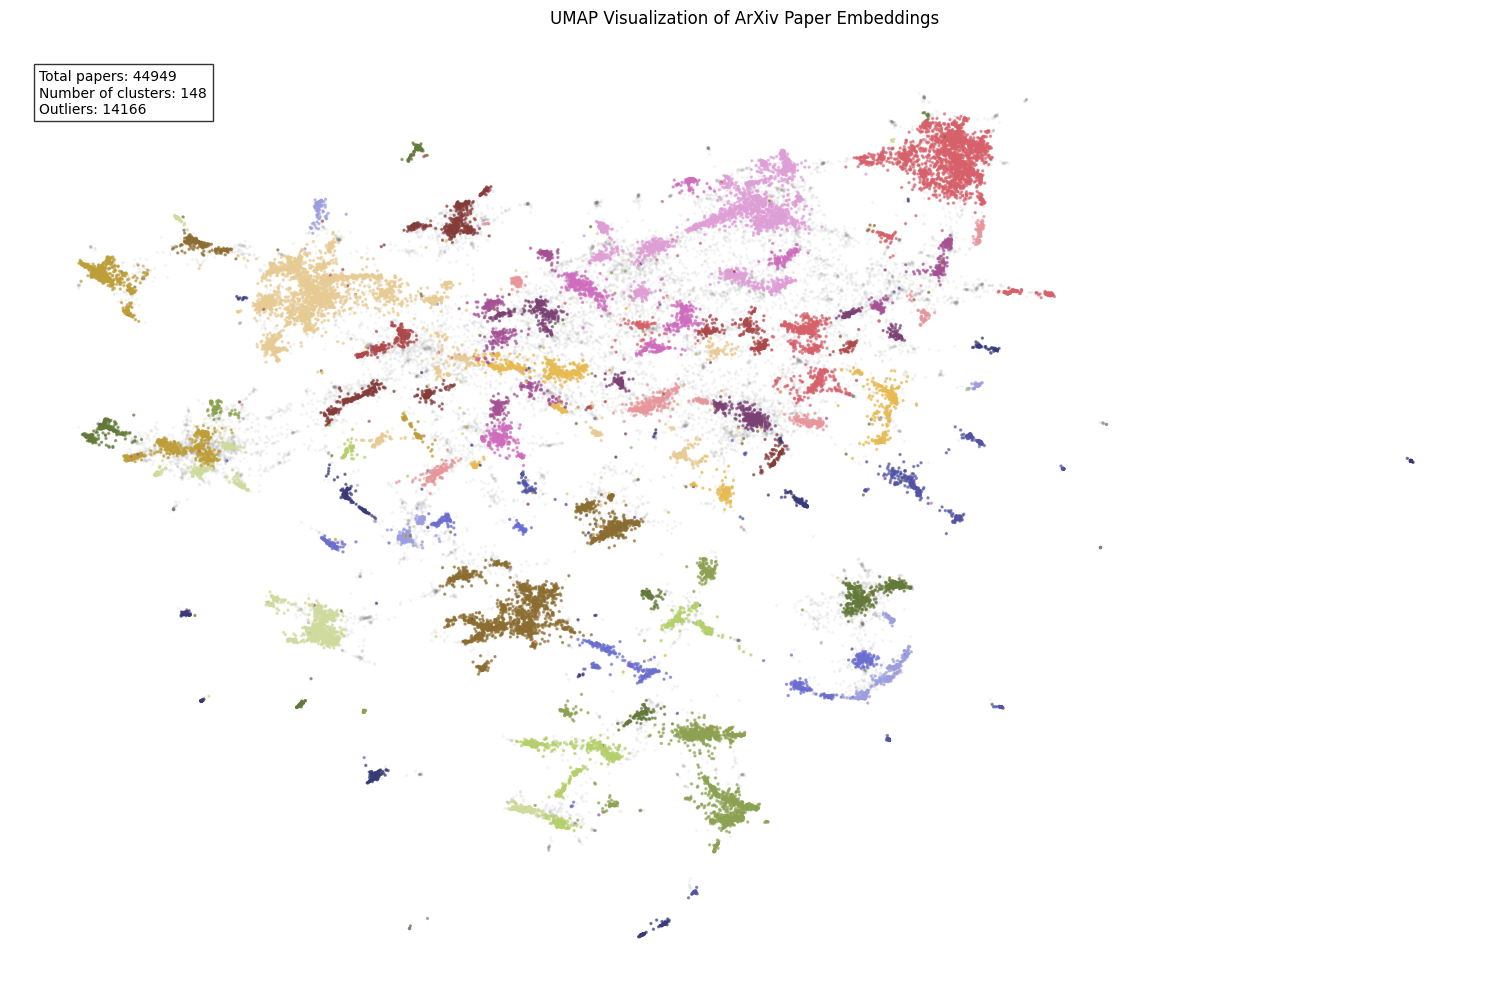

In [127]:
import matplotlib.pyplot as plt

# Create figure with a larger size
plt.figure(figsize=(15, 10))

# Plot outliers
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey", label="Outliers")

# Plot clusters
scatter = plt.scatter(
    clusters_df.x, clusters_df.y,
    c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap="tab20b",
    label="Clusters"
)

# Add legend for clusters
legend1 = plt.legend(*scatter.legend_elements(num=10),
                    loc="upper right", title="Clusters",
                    bbox_to_anchor=(1.15, 1))
plt.gca().add_artist(legend1)

# Add title and info
plt.title("UMAP Visualization of ArXiv Paper Embeddings", pad=20)

# Add text box with stats
stats_text = f"Total papers: {len(df)}\n" \
             f"Number of clusters: {len(set(clusters_df.cluster))}\n" \
             f"Outliers: {len(outliers_df)}"
plt.text(0.02, 0.98, stats_text,
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top')   

plt.axis("off")
plt.tight_layout()

(np.float64(-7.41880168914795),
 np.float64(11.19101848602295),
 np.float64(-1.5701014190912246),
 np.float64(15.24072132408619))

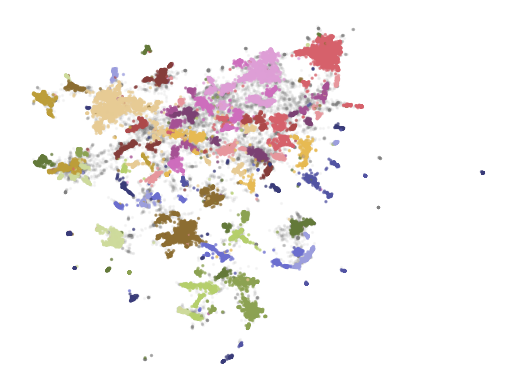

In [126]:
import matplotlib.pyplot as plt
# Plot outliers and non-outliers separately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2,
c="grey")
plt.scatter(
 clusters_df.x, clusters_df.y,
c=clusters_df.cluster.astype(int),
 alpha=0.6, s=2, cmap="tab20b"
)
plt.axis("off")

# Langchain


In [3]:
!pip install langchain langchain-community

  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached httpx_sse-0.4.0-py3-none-any.whl.metadata (9.0 kB)
  Using cached typing_inspect-0.9.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached mypy_extensions-1.0.0-py3-none-any.whl.metadata (1.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 9.2 MB/s eta 0:00:007.5 MB/s eta 0:00:01
Using cached dataclasses_json-0.6.7-py3-none-any.whl (28 kB)
Using cached httpx_sse-0.4.0-py3-none-any.whl (7.8 kB)
Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)
Using cached typing_inspect-0.9.0-py3-none-any.whl (8.8 kB)
Using cached mypy_extensions-1.0.0-py3-none-any.whl (4.7 kB)


# Langchain Openai Agents

In [1]:
!pip install langchain-openai
!pip install -U duckduckgo-search

In [2]:
# read the config 
import yaml 

try:
    with open('config/config.yaml', 'r') as f:
        config = yaml.safe_load(f)
except Exception as e:
    print(f"Failed with error {e}")


In [14]:
import os
from langchain_openai import ChatOpenAI


os.environ['OPENAI_API_KEY'] = config['openai']['api_key']
openai_llm = ChatOpenAI(model_name='gpt-4o',
                        temperature=0)


In [15]:
from langchain import PromptTemplate
# Let's create the react agent ````
react_template = """
Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the actions to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action ... (this Thought/Action/Action Input/Observation cycle can repeat n times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question {input}

Thought: {agent_scratchpad}
"""

prompt = PromptTemplate(
    template=react_template,
    input_variables=['tools', 'tool_names', 'input', 'agent_scrathpad']
)


In [5]:
# let's introduce the tools 
from langchain.agents import load_tools, Tool
from langchain.tools import DuckDuckGoSearchResults

# create a search tool to pass to the LLM
search = DuckDuckGoSearchResults()

search_tool = Tool(
    name='duckduck',
    description='A web search engine. Use this to as a search engine for general queries.',
    func=search.run
)

tools = load_tools(['llm-math'], openai_llm)

tools.append(search_tool)


In [8]:
from langchain.agents import AgentExecutor, create_react_agent

agent= create_react_agent(openai_llm, tools, prompt)

agent_executor = AgentExecutor(
    agent=agent, tools=tools, verbose=True,
    handle_parsing_errors=True
)


In [10]:
agent_output = agent_executor.invoke(
                {
                    "input": "What is the current price of a MacBook Pro in USD? How much would it cost in CAD if the exchange rate is 1.4 CAD for 1 USD."
                }
                )




> Entering new AgentExecutor chain...
To find the current price of a MacBook Pro in USD, I will perform a web search. Then, I will calculate the cost in CAD using the given exchange rate.

Action: duckduck
Action Input: "current price of MacBook Pro in USD"
snippet: For the latest prices and sales, see our 14" MacBook Pro Price Tracker, updated daily ... Read More. December 27, 2024. Holiday Sale: 16-inch M4 Max MacBook Pro for $400 off MSRP at B&H. B&H Photo is offering a $400 discount on new 16-inch MacBook Pros with an M4 Max CPU as part of their ongoing Holiday sales. B&H offers free 1-2 day shipping ..., title: MacPrices.net | The original source for late-breaking Apple sales & deals, link: https://www.macprices.net/, snippet: As of April 2024, the latest MacBook Pro 14-inch M3 model started with a retail price of 1,599 U.S. dollars while the 16-inch M3 Pro version began with a retail price of 2,499 U.S. dollars., title: Apple MacBook Pro price comparison 2024 - Statista, link: 

In [12]:
import json 

print(json.dumps(agent_output, indent=4))

{
    "input": "What is the current price of a MacBook Pro in USD? How much would it cost in CAD if the exchange rate is 1.4 CAD for 1 USD.",
    "output": "The current price of a 14-inch MacBook Pro is $1,599 USD. In CAD, it would cost approximately $2,238.60."
}
